# Livrable 2 - Traitement d'images

Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Vous devez produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.

## Description du livrable

Le notebook devra intégrer :
- Le code de chargement du fichier
- Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.
- Une étude de cas.

Pour réaliser cette phase, vous pourrez exploiter le dataset disponible. Attention, ce dataset contient des images en RGB, ce qui correspon au workflow que vous devrez implémenter tout au long de ce projet.

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr


# mean_squared_error :
# Calcule l'erreur quadratique moyenne entre deux images.
# Plus la valeur est faible, meilleure est la qualité.

# peak_signal_noise_ratio (PSNR) :
# Mesure la qualité de l'image en dB.
# Plus la valeur est élevée, meilleure est la qualité.

### Chargement des images


In [52]:
data_dir = 'dataset_2'
image_files = os.listdir(data_dir)

img_height, img_width, rgb = 256, 256, 3
images = []

for img_file in image_files:
    img_path = os.path.join(data_dir, img_file)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images)

# Normalisation des images
normalized_images = images / 255.0

### Partie 1 : Bruit gaussien léger (0.15)

Le bruit gaussien est un type de bruit aléatoire ajouté à une image, dont la distribution suit une loi normale (gaussienne). Il est caractérisé par une moyenne et un écart-type, et affecte les pixels de manière aléatoire, créant une variation d'intensité lumineuse. Il est souvent utilisé pour simuler les imperfections dans les systèmes d'acquisition d'images, comme les capteurs d'appareils photo.

In [53]:
# Ajout d'un bruit gaussien léger (0.15)
noise_factor_015 = 0.15
noisy_images_015 = normalized_images + noise_factor_015 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_015 = np.clip(noisy_images_015, 0., 1.)

# Séparation en ensembles d'entraînement et de test pour le bruit léger
X_train_015, X_test_015, y_train_015, y_test_015 = train_test_split(
    noisy_images_015, normalized_images, test_size=0.2, random_state=42
) 
#Le bruit en traitement d'images fait référence aux variations aléatoires ou perturbations qui altèrent la qualité d'une image

# Construction de l'auto-encodeur
input_img = Input(shape=(img_height, img_width, rgb))

Encodage : réduit les informations complexes (ex. une image) en une représentation compacte, souvent en capturant les caractéristiques principales avec des couches convolutives dans un réseau de neurones.

Décodage : reconstruit l'information d'origine à partir de cette représentation compacte, en agrandissant progressivement les données via des couches de transposition ou d'upsampling.

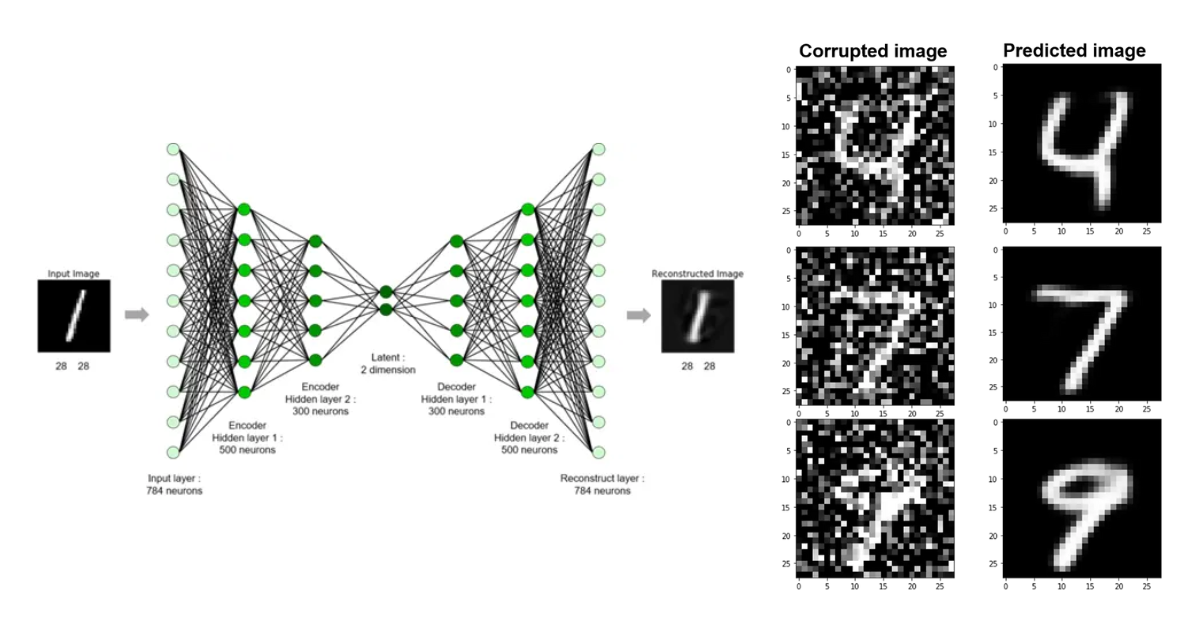

In [54]:
# Encodeur
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Décodeur
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(rgb, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_015 = Model(input_img, decoded)
autoencoder_015.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [55]:
# Entraînement du modèle pour le bruit léger
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
try:
    autoencoder_015.load_weights('autoencoder_15.weights.h5')
except:
    history_015 = autoencoder_015.fit(
        X_train_015, y_train_015, epochs=150, batch_size=4, shuffle=True,
        validation_data=(X_test_015, y_test_015), callbacks=[early_stopping]
    )

autoencoder_015.save_weights('autoencoder_15.weights.h5')

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - accuracy: 0.4027 - loss: 0.6516 - val_accuracy: 0.6289 - val_loss: 0.5809
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.6454 - loss: 0.5546 - val_accuracy: 0.6376 - val_loss: 0.5565
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.6929 - loss: 0.5450 - val_accuracy: 0.6640 - val_loss: 0.5468
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.6151 - loss: 0.5364 - val_accuracy: 0.6839 - val_loss: 0.5516
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.6774 - loss: 0.5246 - val_accuracy: 0.7065 - val_loss: 0.5481
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.7106 - loss: 0.5434 - val_accuracy: 0.7248 - val_loss: 0.5385
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.6676 - loss: 0.5362 - val_accuracy: 0.7492 - val_loss: 0.5364
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.7349 - loss: 0.5361 - val_accu

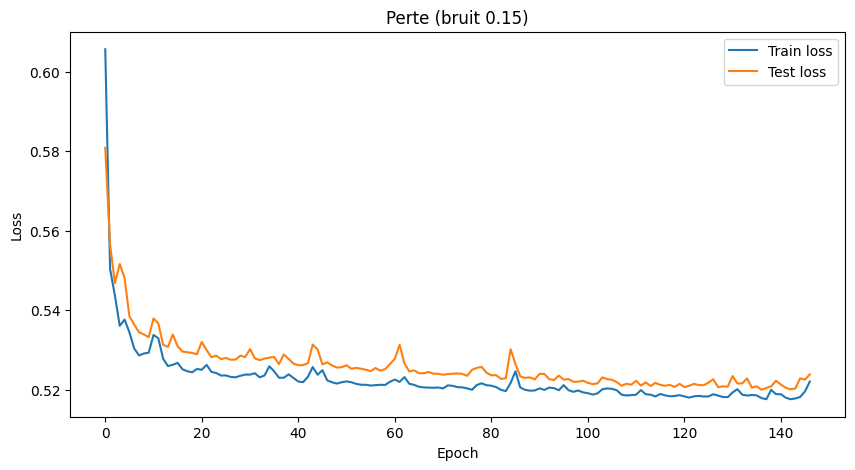

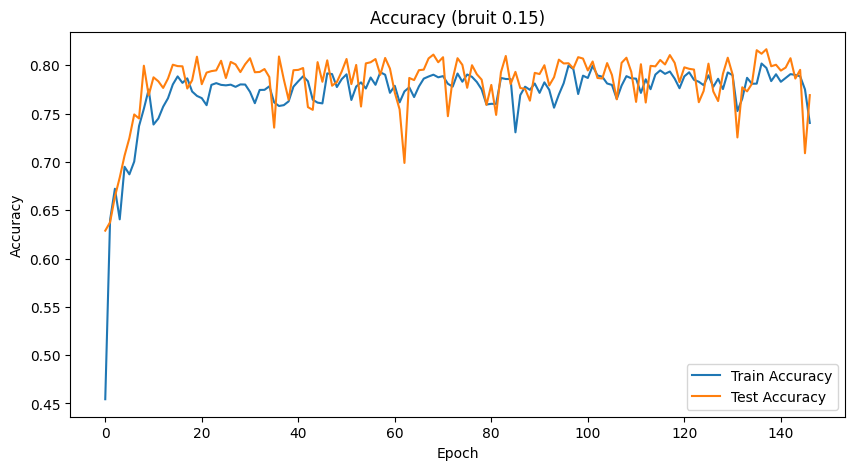

In [56]:
# Visualisation des pertes et accuracies
plt.figure(figsize=(10, 5))
plt.plot(history_015.history['loss'], label='Train loss')
plt.plot(history_015.history['val_loss'], label='Test loss')
plt.title('Perte (bruit 0.15)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_015.history['accuracy'], label='Train Accuracy')
plt.plot(history_015.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy (bruit 0.15)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**PSNR (Peak Signal-to-Noise Ratio)** : mesure la qualité d'une image débruitée en comparant l'image originale et la version débruitée. Plus le PSNR est élevé, meilleure est la qualité. Il est exprimé en décibels (dB).

**SSIM (Structural Similarity Index)** : évalue la similitude structurelle entre l'image originale et l'image débruitée. Contrairement au PSNR, qui se base sur les différences de pixel, le SSIM prend en compte les contrastes, la luminance et la structure de l'image. Sa valeur varie de 0 à 1, où 1 représente une correspondance parfaite.

In [57]:
# Calcul des performances PSNR et MSE pour le bruit léger
decoded_imgs_015 = autoencoder_015.predict(X_test_015)

psnr_vals_015 = [psnr(orig, pred, data_range=orig.max() - orig.min()) for orig, pred in zip(y_test_015, decoded_imgs_015)]
mean_psnr_015 = np.mean(psnr_vals_015)
print(f"Mean PSNR (0.15): {mean_psnr_015:.2f}")

mse_vals_015 = [mean_squared_error(orig.flatten(), pred.flatten()) for orig, pred in zip(y_test_015, decoded_imgs_015)]
mean_mse_015 = np.mean(mse_vals_015)
print(f"Mean MSE (0.15): {mean_mse_015:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Mean PSNR (0.15): 23.47
Mean MSE (0.15): 0.005


### Partie 1 : Bruit gaussien léger (0.15)

In [58]:
# Ajout d'un bruit gaussien fort (0.40)
noise_factor_040 = 0.40
noisy_images_040 = normalized_images + noise_factor_040 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_040 = np.clip(noisy_images_040, 0., 1.)

# Séparation en ensembles d'entraînement et de test pour le bruit fort
X_train_040, X_test_040, y_train_040, y_test_040 = train_test_split(
    noisy_images_040, normalized_images, test_size=0.2, random_state=42
)

# Construction de l'auto-encodeur (même architecture)
autoencoder_040 = autoencoder_015

In [59]:
try:
    # Reconstruire le modèle avec la même architecture
    autoencoder_040.load_weights('autoencoder_40.weights.h5')

except:
    # Entraînement du modèle pour le bruit fort
    history_040 = autoencoder_040.fit(
        X_train_040, y_train_040, epochs=150, batch_size=4, shuffle=True,
        validation_data=(X_test_040, y_test_040), callbacks=[early_stopping]
    )

autoencoder_040.save_weights('autoencoder_40.weights.h5')

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.6821 - loss: 0.5456 - val_accuracy: 0.6619 - val_loss: 0.5373
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.6740 - loss: 0.5372 - val_accuracy: 0.7223 - val_loss: 0.5361
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.7282 - loss: 0.5417 - val_accuracy: 0.7234 - val_loss: 0.5324
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.6926 - loss: 0.5306 - val_accuracy: 0.7395 - val_loss: 0.5315
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.7099 - loss: 0.5331 - val_accuracy: 0.7296 - val_loss: 0.5311
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.7261 - loss: 0.5298 - val_accuracy: 0.7113 - val_loss: 0.5319
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.7265 - loss: 0.5344 - val_accuracy: 0.7301 - val_loss: 0.5320
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.6893 - loss: 0.5287 - val_accu

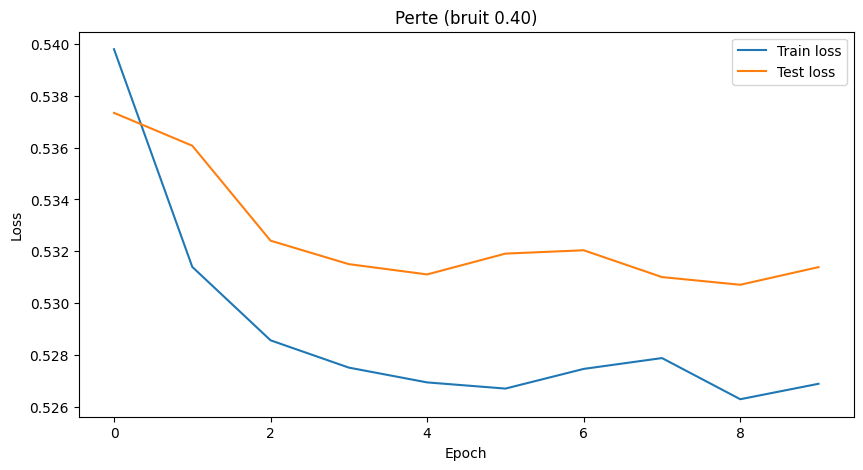

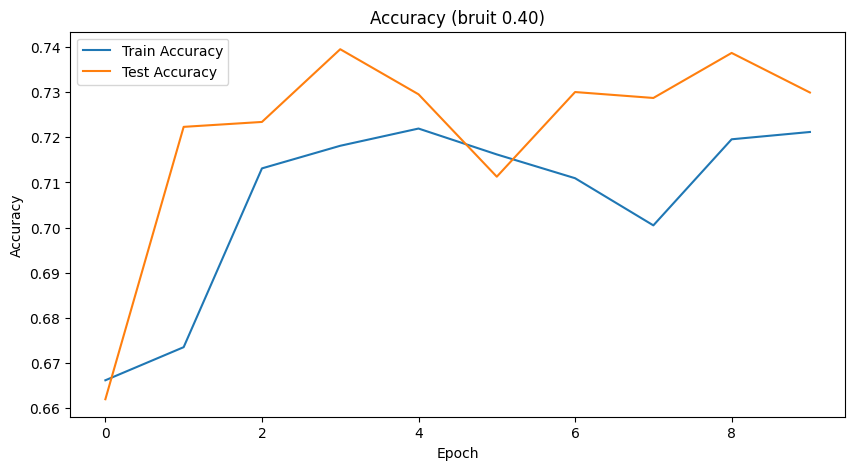

In [60]:
# Visualisation des pertes et accuracies
plt.figure(figsize=(10, 5))
plt.plot(history_040.history['loss'], label='Train loss')
plt.plot(history_040.history['val_loss'], label='Test loss')
plt.title('Perte (bruit 0.40)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_040.history['accuracy'], label='Train Accuracy')
plt.plot(history_040.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy (bruit 0.40)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
# Calcul des performances PSNR et MSE pour le bruit fort
decoded_imgs_040 = autoencoder_040.predict(X_test_040)

psnr_vals_040 = [psnr(orig, pred, data_range=orig.max() - orig.min()) for orig, pred in zip(y_test_040, decoded_imgs_040)]
mean_psnr_040 = np.mean(psnr_vals_040)
print(f"Mean PSNR (0.40): {mean_psnr_040:.2f}")

mse_vals_040 = [mean_squared_error(orig.flatten(), pred.flatten()) for orig, pred in zip(y_test_040, decoded_imgs_040)]
mean_mse_040 = np.mean(mse_vals_040)
print(f"Mean MSE (0.40): {mean_mse_040:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Mean PSNR (0.40): 19.73
Mean MSE (0.40): 0.012


### Affichage des images et résultats

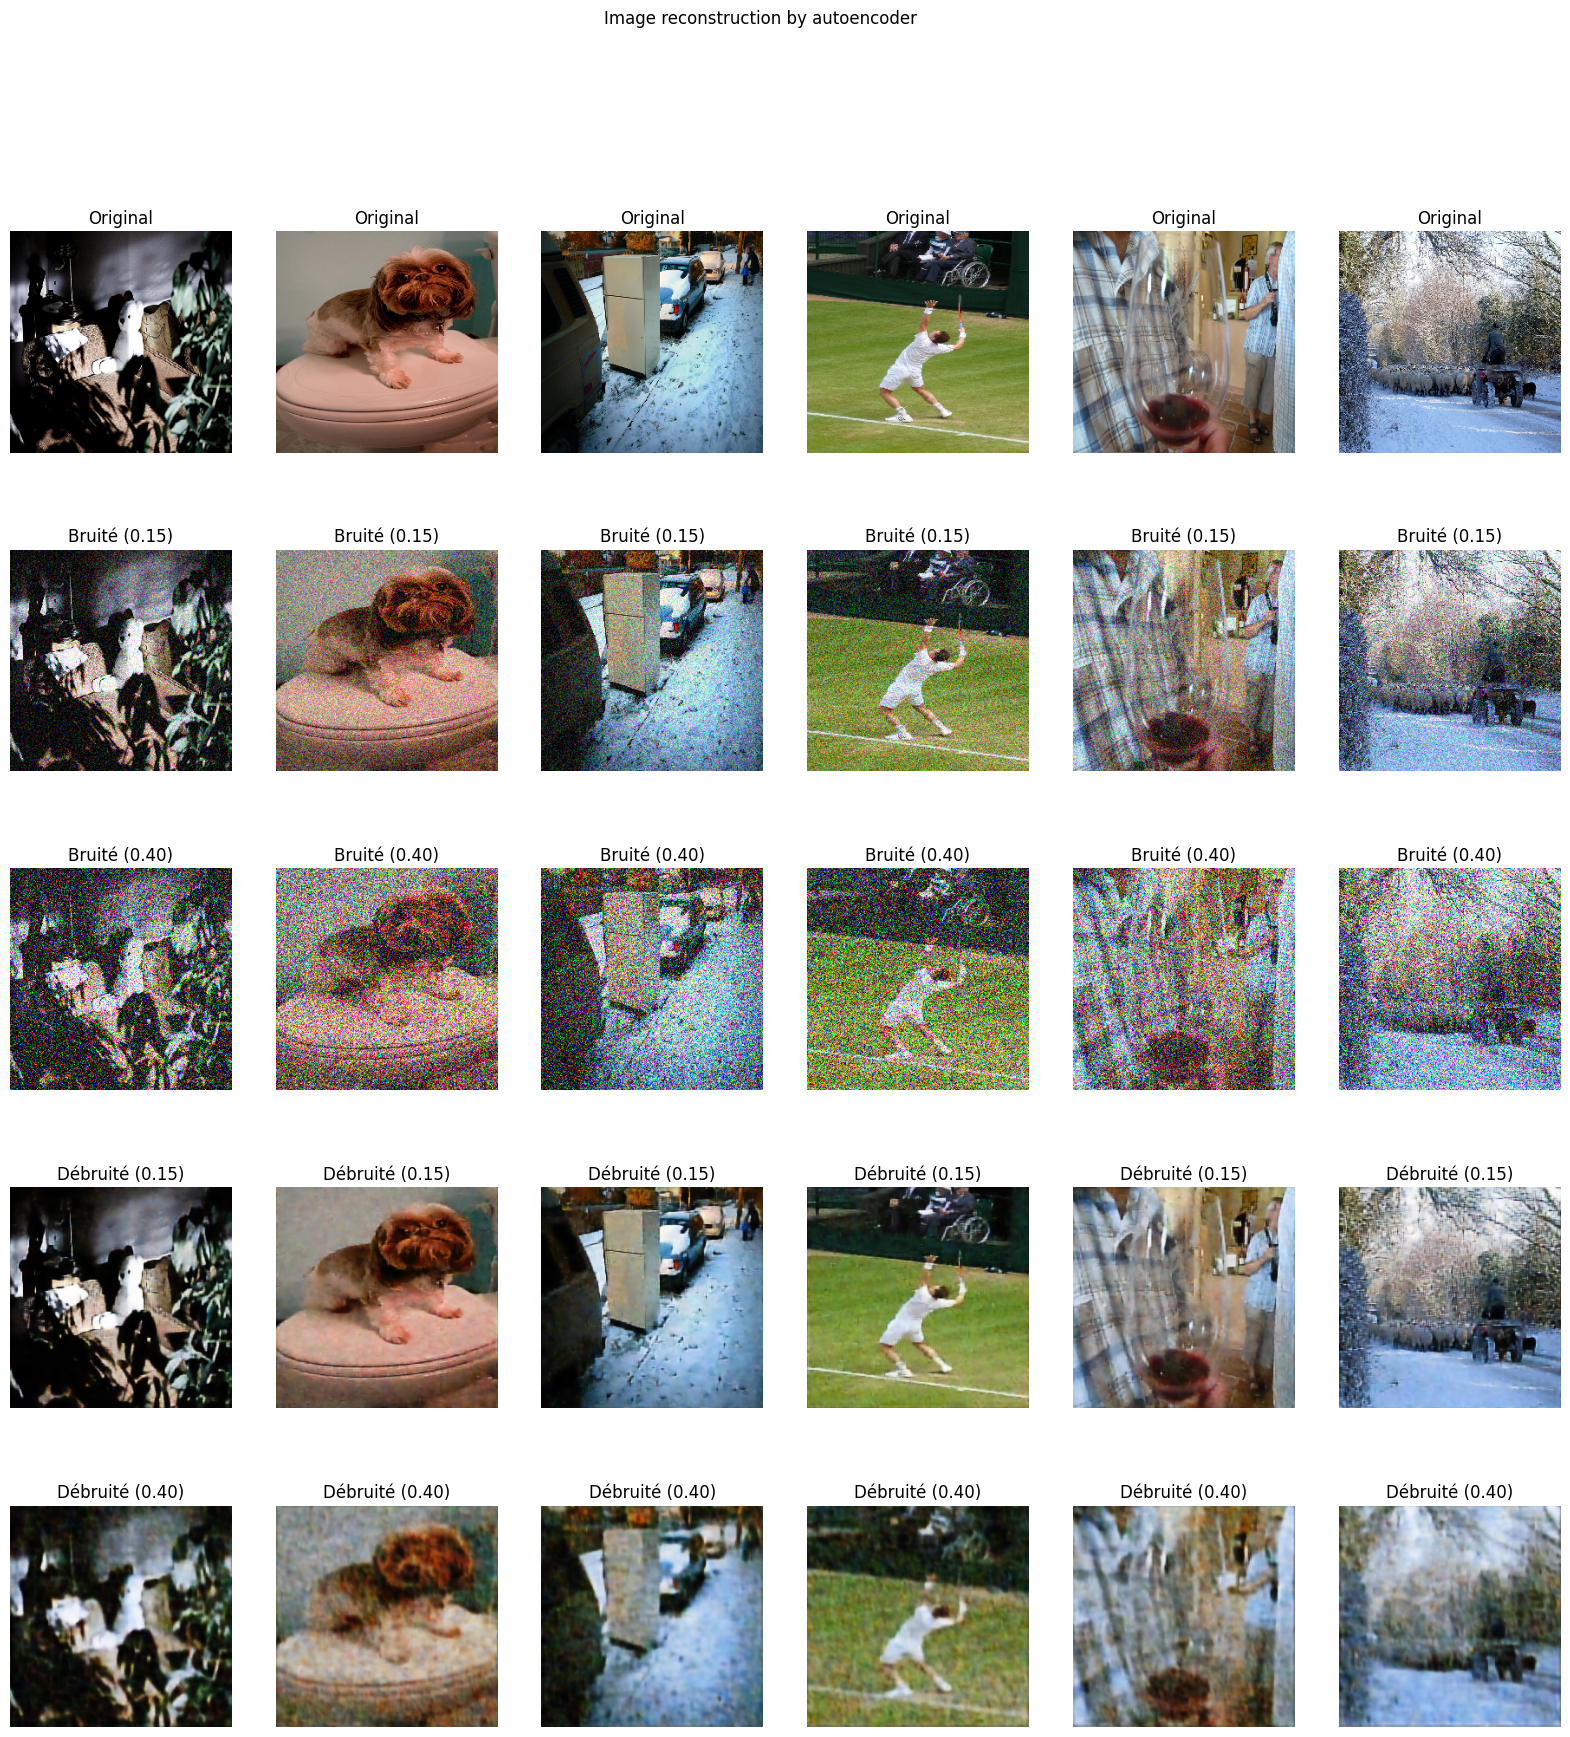

In [62]:
# Affichage des images originales, bruitées et débruitées
plt.figure(figsize=(20,20))
num_images_to_show = 6

for i in range(num_images_to_show):
    # Images originales
    ax = plt.subplot(5, num_images_to_show, i + 1)
    plt.imshow(y_test_015[i].reshape(img_height, img_width, rgb))
    plt.title("Original")
    plt.axis("off")
    
    # Images légèrement bruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(X_test_015[i].reshape(img_height, img_width, rgb))
    plt.title("Bruité (0.15)")
    plt.axis("off")

    # Images fortement bruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + 2*num_images_to_show)
    plt.imshow(X_test_040[i].reshape(img_height, img_width, rgb))
    plt.title("Bruité (0.40)")
    plt.axis("off")
    
    # Images légèrement bruitées débruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + 3*num_images_to_show)
    plt.imshow(decoded_imgs_015[i].reshape(img_height, img_width, rgb))
    plt.title("Débruité (0.15)")
    plt.axis("off")

    # Images fortement bruitées débruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + 4*num_images_to_show)
    plt.imshow(decoded_imgs_040[i].reshape(img_height, img_width, rgb))
    plt.title("Débruité (0.40)")
    plt.axis("off")

plt.suptitle("Image reconstruction by autoencoder")
plt.show()

Bruit (0.15) : Le bruit n'est pas trop intense, mais il perturbe encore légèrement les détails de l'image. Le réseau de l'autoencodeur semble avoir bien débruité les images, conservant une bonne qualité visuelle.
Bruit (0.40) : Avec une plus grande quantité de bruit, les images sont fortement dégradées. Les résultats après débruitage sont nettement améliorés, mais certaines textures fines ou détails précis sont encore légèrement flous ou altérés.

Les performances de l'autoencodeur semblent raisonnables pour des niveaux de bruit modérés (0.15), mais lorsqu'il y a plus de bruit (0.40), il y a une dégradation notable de la qualité des images après débruitage. Il serait intéressant d'explorer des améliorations dans l'architecture (comme l'ajout de couches plus profondes ou l'utilisation d'une perte perceptuelle) pour mieux capturer les détails fins dans les cas de bruit élevé.